In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pysentani as sti

Create a dataframe with only appliance ownership and willingness to purchase columns and then drop any null responses.

In [9]:
survey = pd.read_excel('../data-anonymous/sentani-merged-cleaned-anonymous-2014-11-29.xlsx')
# pysentani access type function
survey['access_type'] = sti.access_type(survey)
# selecting columns to analyze
survey = survey[['app_now/rice_cooker',
                 'app_now/TV',
                 'app_now/fridge',
                 'app_now/fan',
                 'app_now/lighting',
                 'app_now/radio',
                 'app_buy/rice_cooker',
                 'app_buy/TV',
                 'app_buy/fridge',
                 'app_buy/fan',
                 'app_buy/lighting',
                 'app_buy/radio',
                 'access_type',]]
# dropping all NaN values for above columns
# we don't need to do these per appliance because the nulls are correlated
survey = survey.dropna()

In [10]:
def willing_to_buy(row, now=None, buy=None):
    if row[now]==1:
        # we return zero in the case where we want to determine the latent demand
        #return np.nan
        return 0
    if row[now]==0 and row[buy]==0:
        return 0
    if row[now]==0 and row[buy]==1:
        return 1
    
def calc_willingness(survey, appliance):
    app_now_appliance = 'app_now/' + appliance
    app_buy_appliance = 'app_buy/' + appliance
    # when we average this, do we exclude the folks with the appliance?
    #survey['wb/' + appliance] = ~survey[app_now_appliance].astype(bool) & survey[app_buy_appliance].astype(bool)
    survey['wb/' + appliance] = survey.apply(willing_to_buy, 
                                axis=1, 
                                now=app_now_appliance,
                                buy=app_buy_appliance)
    
    
appliance_list = ['TV', 'lighting', 'radio', 'rice_cooker', 'fridge', 'fan' ]

# Creating variable with for loop adding each from appliance_list to calc_willingess function
WBlist = []
for appliance in appliance_list:
    calc_willingness(survey, appliance)
    WBlist.append('wb/' + appliance)

Split dataframe into pieces for each analysis to determine the percentage of current ownership and households that will purchase that currently do not own the appliance.  We also rename the columns to facilitate addition later.

In [11]:
app_now = survey[['app_now/rice_cooker',
                 'app_now/TV',
                 'app_now/fridge',
                 'app_now/fan',
                 'app_now/lighting',
                 'app_now/radio',
                 'access_type',]]

app_buy = survey[['app_buy/rice_cooker',
                 'app_buy/TV',
                 'app_buy/fridge',
                 'app_buy/fan',
                 'app_buy/lighting',
                 'app_buy/radio',
                 'access_type',]]

wb = survey[['wb/rice_cooker',
                 'wb/TV',
                 'wb/fridge',
                 'wb/fan',
                 'wb/lighting',
                 'wb/radio',
                 'access_type',]]

app_now.columns = [col.replace('app_now/', '') for col in app_now.columns]
app_buy.columns = [col.replace('app_buy/', '') for col in app_buy.columns]
wb.columns = [col.replace('wb/', '') for col in wb.columns]

Group by access type and take averages.  app_now_mean is the percentage of current ownership and app_buy_mean is the overall percentage that are likely to purchase.  Adding these together gives the overall post-electrification ownership percentage.  We then do some manipulation to get the data in tidy format.

In [12]:
app_now_mean = app_now.groupby('access_type').mean().stack()
app_buy_mean = wb.groupby('access_type').mean().stack()

future_electrification = app_buy_mean + app_now_mean 
fe_tidy = future_electrification.reset_index()
fe_tidy.rename(columns={'level_1':'Appliance', 0:'Percent Ownership'},
              inplace=True)
fe_tidy.head()

,access_type,Appliance,Percent Ownership
0,PLN_grid,rice_cooker,0.494005
1,PLN_grid,TV,0.944844
2,PLN_grid,fridge,0.812950
3,PLN_grid,fan,0.316547
4,PLN_grid,lighting,0.937650


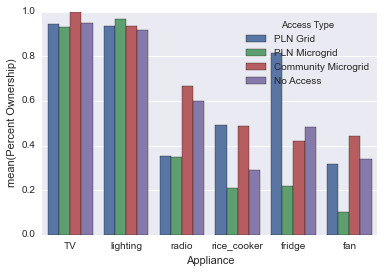

In [13]:
# renaming subcategories of Access Type
fe_tidy.replace(to_replace = {'access_type': {'PLN_grid': 'PLN Grid',
                                             'community_microgrid': 'Community Microgrid',
                                             'PLN_microgrid': 'PLN Microgrid',
                                             'no_access': 'No Access'}},inplace = True)
fe_tidy.rename(columns={'access_type':'Access Type'}, inplace=True)
sns.barplot(hue='Access Type', y='Percent Ownership', x='Appliance', 
            order=['TV', 'lighting', 'radio', 'rice_cooker', 'fridge', 'fan'], data=fe_tidy)
plt.savefig('post-electrification-ownership.png')

I'm still concerned about the difference between the two microgrid categories.  My hunch is that there is something biased in the data beteen those that we don't understand yet.